In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-07-08 10:23:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
正在解析主机 storage.googleapis.com (storage.googleapis.com)... 34.64.4.112, 34.64.4.16, 34.64.4.80
正在连接 storage.googleapis.com (storage.googleapis.com)|34.64.4.112|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：149574867 (143M) [application/zip]
正在保存至: “/tmp/horse-or-human.zip”

/tmp/horse-or-human 100%[===================>] 142.65M   564KB/s  用时 5m 6s     

2020-07-08 10:28:13 (477 KB/s) - 已保存 “/tmp/horse-or-human.zip” [149574867/149574867])



In [3]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [4]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [5]:
train_horse_dir

'/tmp/horse-or-human/horses'

In [6]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse43-5.png', 'horse06-5.png', 'horse20-6.png', 'horse04-7.png', 'horse41-7.png', 'horse22-4.png', 'horse19-2.png', 'horse24-2.png', 'horse37-8.png', 'horse02-1.png']
['human17-22.png', 'human10-17.png', 'human10-03.png', 'human07-27.png', 'human09-22.png', 'human05-22.png', 'human02-03.png', 'human02-17.png', 'human15-27.png', 'human12-12.png']


In [7]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

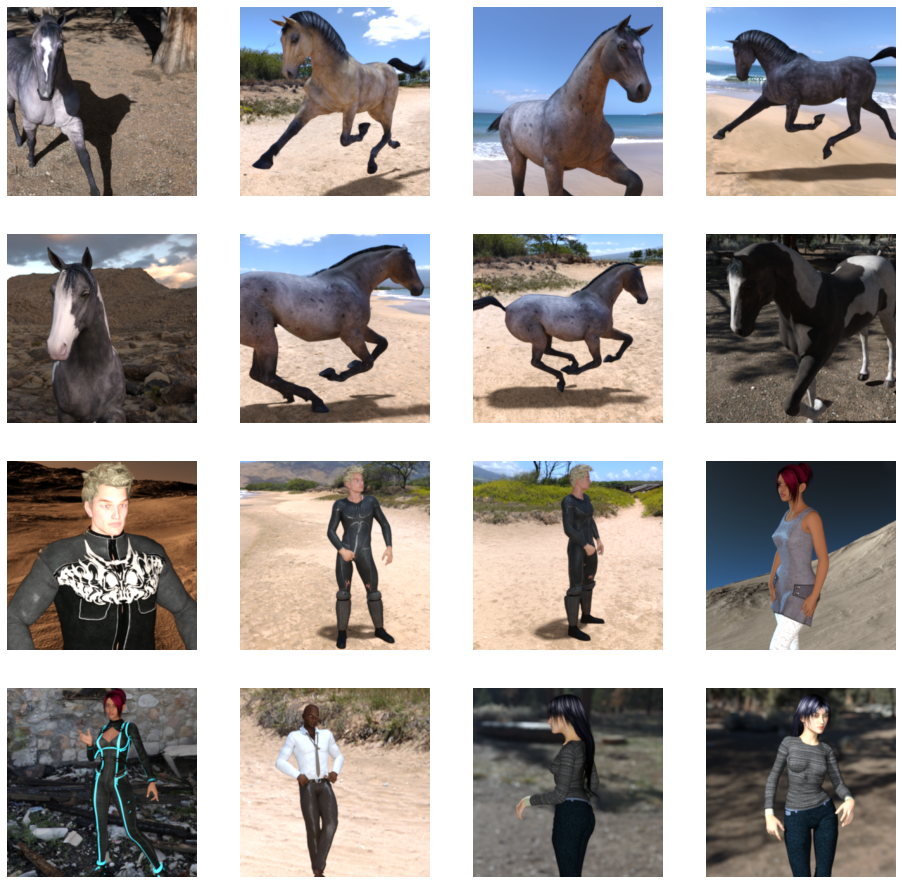

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


In [14]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=10,
      verbose=1)

  ...
    to  
  ['...']
Train for 8 steps
Epoch 1/10
8/8 [==============================] - 40s 5s/step - loss: 1.0340 - accuracy: 0.5751
Epoch 2/10
8/8 [==============================] - 46s 6s/step - loss: 0.7324 - accuracy: 0.5717
Epoch 3/10
8/8 [==============================] - 46s 6s/step - loss: 1.5766 - accuracy: 0.8020
Epoch 4/10
8/8 [==============================] - 39s 5s/step - loss: 0.5345 - accuracy: 0.7519
Epoch 5/10
8/8 [==============================] - 38s 5s/step - loss: 0.3309 - accuracy: 0.8838
Epoch 6/10
8/8 [==============================] - 43s 5s/step - loss: 0.4419 - accuracy: 0.8509
Epoch 7/10
8/8 [==============================] - 53s 7s/step - loss: 0.1604 - accuracy: 0.9377
Epoch 8/10
8/8 [==============================] - 54s 7s/step - loss: 0.3281 - accuracy: 0.8888
Epoch 9/10
8/8 [==============================] - 51s 6s/step - loss: 0.1357 - accuracy: 0.9477
Epoch 10/10
8/8 [==============================] - 49s 6s/step - loss: 0.1636 - accuracy: 0.9

In [15]:
# Try yourself
#
import numpy as np
from tensorflow.keras.preprocessing import image

path='./HorseOrHuman/Horse1.jpg'

def HorseOrHuman(path):
    fn=path.split('/')[-1]
    img = image.load_img(path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")
    
HorseOrHuman(path)

[7.1694675e-19]
Horse1.jpg is a horse
